<h1>**Table of Contents**<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-engineering---quantifying-access-to-facilities" data-toc-modified-id="Feature-engineering---quantifying-access-to-facilities-1">Feature engineering - quantifying access to facilities</a></span><ul class="toc-item"><li><span><a href="#Read-one-of-the-shortlisted-properties" data-toc-modified-id="Read-one-of-the-shortlisted-properties-1.1">Read one of the shortlisted properties</a></span></li><li><span><a href="#Create-symbols-for-facilities" data-toc-modified-id="Create-symbols-for-facilities-1.2">Create symbols for facilities</a></span><ul class="toc-item"><li><span><a href="#Get-5-mile-extent-around-the-property-of-interest" data-toc-modified-id="Get-5-mile-extent-around-the-property-of-interest-1.2.1">Get 5 mile extent around the property of interest</a></span></li><li><span><a href="#Plot-house-and-buffer-on-map" data-toc-modified-id="Plot-house-and-buffer-on-map-1.2.2">Plot house and buffer on map</a></span></li></ul></li><li><span><a href="#Geocode-for-facilities" data-toc-modified-id="Geocode-for-facilities-1.3">Geocode for facilities</a></span><ul class="toc-item"><li><span><a href="#Groceries" data-toc-modified-id="Groceries-1.3.1">Groceries</a></span></li><li><span><a href="#Restaurants" data-toc-modified-id="Restaurants-1.3.2">Restaurants</a></span></li><li><span><a href="#Hospitals" data-toc-modified-id="Hospitals-1.3.3">Hospitals</a></span></li><li><span><a href="#Coffee-shops" data-toc-modified-id="Coffee-shops-1.3.4">Coffee shops</a></span></li><li><span><a href="#Bars" data-toc-modified-id="Bars-1.3.5">Bars</a></span></li><li><span><a href="#Gas-stations" data-toc-modified-id="Gas-stations-1.3.6">Gas stations</a></span></li><li><span><a href="#Shops-and-service" data-toc-modified-id="Shops-and-service-1.3.7">Shops and service</a></span></li><li><span><a href="#Travel-and-transport" data-toc-modified-id="Travel-and-transport-1.3.8">Travel and transport</a></span></li><li><span><a href="#Parks-and-outdoors" data-toc-modified-id="Parks-and-outdoors-1.3.9">Parks and outdoors</a></span></li><li><span><a href="#Education" data-toc-modified-id="Education-1.3.10">Education</a></span></li><li><span><a href="#Present-the-results-in-a-table" data-toc-modified-id="Present-the-results-in-a-table-1.3.11">Present the results in a table</a></span></li><li><span><a href="#Find-duration-to-commute-to-work" data-toc-modified-id="Find-duration-to-commute-to-work-1.3.12">Find duration to commute to work</a></span></li></ul></li></ul></li></ul></div>

# Feature engineering - quantifying access to facilities
Often, when shortlisting facilities buyers look for access to facilities such as groceries, restaurants, schools, emergency and health care in thier neighborhood. In this notebook, we use the `geocoding` module to search for such facilities and build a table for each property.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

from arcgis.gis import GIS
from arcgis.geocoding import geocode
from arcgis.features import Feature, FeatureLayer, FeatureSet, GeoAccessor, GeoSeriesAccessor
from arcgis.features import SpatialDataFrame
from arcgis.geometry import Geometry, Point
from arcgis.geometry.functions import buffer
from arcgis.network import RouteLayer

Connect to GIS

In [2]:
gis = GIS(profile='')

## Read one of the shortlisted properties

In [3]:
prop_list_df = pd.read_csv('resources/houses_for_sale_att_filtered.csv')
prop_list_df.shape

(331, 24)

In [4]:
prop_list_df = pd.DataFrame.spatial.from_xy(prop_list_df, 'LONGITUDE','LATITUDE')
type(prop_list_df)

pandas.core.frame.DataFrame

In [5]:
prop1 = prop_list_df[prop_list_df['MLS']==18389440]
prop1

,Unnamed: 0,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIP,PRICE,BEDS,BATHS,...,DAYS ON MARKET,PRICE PER SQFT,HOA PER MONTH,STATUS,URL,SOURCE,MLS,LATITUDE,LONGITUDE,SHAPE
203,2328,MLS Listing,Single Family Residential,3775 NW Hilton Head Ter,Portland,OR,97229.0,649900.0,4.0,2.5,...,21.0,221.0,25.0,Active,http://www.redfin.com/OR/Portland/3775-NW-Hilt...,RMLS,18389440,45.546644,-122.815658,"{""x"": -122.8156584, ""y"": 45.546644, ""spatialRe..."


## Create symbols for facilities
Get your symbols using this online tool: [http://esri.github.io/arcgis-python-api/tools/symbol.html](http://esri.github.io/arcgis-python-api/tools/symbol.html)

In [6]:
house_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Shapes/RedStarLargeB.png","contentType":"image/png","width":24,"height":24}
grocery_symbol = symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/Shopping.png","contentType":"image/png","width":12,"height":12}
hospital_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/SafetyHealth/Hospital.png","contentType":"image/png","width":24,"height":24}
coffee_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/Coffee.png","contentType":"image/png","width":12,"height":12}
restaurant_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/Dining.png","contentType":"image/png","width":12,"height":12}
bar_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/Bar.png","contentType":"image/png","width":12,"height":12}
gas_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Transportation/esriBusinessMarker_72.png","contentType":"image/png","width":12,"height":12}
shops_service_symbol={"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/esriBusinessMarker_58_Red.png","contentType":"image/png","width":10,"height":10}
transport_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Transportation/esriDefaultMarker_195_White.png","contentType":"image/png","width":15,"height":15}
professional_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/esriBusinessMarker_64_Yellow.png","contentType":"image/png","width":10,"height":10}
parks_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/OutdoorRecreation/RestArea.png","contentType":"image/png","width":10,"height":10}
education_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/Note.png","contentType":"image/png","width":10,"height":10}
arts_symbol = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/LiveShow.png","contentType":"image/png","width":12,"height":12}
destination_symbol = {"angle":0,"xoffset":0,"yoffset":12,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Basic/RedStickpin.png","contentType":"image/png","width":24,"height":24}
fill_symbol = {"type": "esriSFS","style": "esriSFSNull",
               "outline":{"color": [255,0,0,255]}}

fill_symbol2 = {"type": "esriSFS","style": "esriSFSNull",
               "outline":{"color": [0,0,0,255]}}

route_symbol = {"type": "esriSLS","style": "esriSLSSolid",
                "color": [0, 120, 255, 255],"width": 1.5}

### Get 5 mile extent around the property of interest

In [7]:
paddress = prop1.ADDRESS + ", " + prop1.CITY + ", " + prop1.STATE
prop_geom_fset = geocode(paddress.values[0], as_featureset=True)

Create an envelope around the property using its extent

In [8]:
prop_geom = prop_geom_fset.features[0]
prop_geom.geometry

{'x': -122.81532305026238,
 'y': 45.54674878544642,
 'spatialReference': {'wkid': 4326, 'latestWkid': 4326}}

In [9]:
prop_geom = prop_geom_fset.features[0]
prop_buffer = buffer([prop_geom.geometry], 
                     in_sr = 102100, buffer_sr=102100,
                     distances=0.05, unit=9001)[0]

prop_buffer_f = Feature(geometry=prop_buffer)
prop_buffer_fset = FeatureSet([prop_buffer_f])

### Plot house and buffer on map

In [10]:
pdx_map = gis.map('Portland, OR')
pdx_map.basemap='gray'
pdx_map

MapView(basemap='gray', layout=Layout(height='400px', width='100%'))

![](resources/map12.png)

In [11]:
pdx_map.draw(prop_buffer_fset, symbol=fill_symbol2)
pdx_map.draw(prop_geom_fset, symbol=house_symbol)

## Geocode for facilities
We use the ArcGIS Geocoding service to search for facilities around this house

### Groceries

In [15]:
neighborhood_data_dict = {}

In [16]:
groceries = geocode('groceries', search_extent=prop_buffer.extent, 
                    max_locations=20, as_featureset=True)
neighborhood_data_dict['groceries'] = []

for place in groceries:
    popup={"title" : place.attributes['PlaceName'], 
    "content" : place.attributes['Place_addr']}
    pdx_map.draw(place.geometry, symbol=grocery_symbol, popup=popup)
    neighborhood_data_dict['groceries'].append(place.attributes['PlaceName'])

We will geocode for the following facilities within the said `5` mile buffer.

    Groceries
    Restaurants
    Hospitals
    Coffee shops
    Bars
    Gas stations
    Shops and service
    Travel and transport
    Parks and outdoors
    Education

###  Restaurants

In [48]:
pdx_map2 = gis.map('Portland, OR')
pdx_map2.basemap='gray'
pdx_map2

MapView(basemap='gray', layout=Layout(height='400px', width='100%'))

![](resources/map8.png)

![](resources/map9.png)

![](resources/map10.png)

In [59]:
pdx_map2.draw(prop_buffer_fset, symbol=fill_symbol2)
pdx_map2.draw(prop_geom_fset, symbol=house_symbol)

In [21]:
restaurants = geocode('restaurant', search_extent=prop_buffer.extent, max_locations=200)
neighborhood_data_dict['restauruants'] = []

for place in restaurants:
    popup={"title" : place['attributes']['PlaceName'], 
    "content" : place['attributes']['Place_addr']}
    pdx_map2.draw(place['location'], symbol=restaurant_symbol, popup=popup)
    neighborhood_data_dict['restauruants'].append(place['attributes']['PlaceName'])

### Hospitals

In [51]:
hospitals = geocode('hospital', search_extent=prop_buffer.extent, max_locations=50)
neighborhood_data_dict['hospitals'] = []

for place in hospitals:
    popup={"title" : place['attributes']['PlaceName'], 
    "content" : place['attributes']['Place_addr']}
    pdx_map2.draw(place['location'], symbol=hospital_symbol, popup=popup)
    neighborhood_data_dict['hospitals'].append(place['attributes']['PlaceName'])

### Coffee shops

In [52]:
coffees = geocode('coffee', search_extent=prop_buffer.extent, max_locations=50)
neighborhood_data_dict['coffees'] = []

for place in coffees:
    popup={"title" : place['attributes']['PlaceName'], 
    "content" : place['attributes']['Place_addr']}
    pdx_map2.draw(place['location'], symbol=coffee_symbol, popup=popup)
    neighborhood_data_dict['coffees'].append(place['attributes']['PlaceName'])

### Bars

In [53]:
bars = geocode('bar', search_extent=prop_buffer.extent, max_locations=50)
neighborhood_data_dict['bars'] = []

for place in bars:
    popup={"title" : place['attributes']['PlaceName'], 
    "content" : place['attributes']['Place_addr']}
    pdx_map2.draw(place['location'], symbol=bar_symbol, popup=popup)
    neighborhood_data_dict['bars'].append(place['attributes']['PlaceName'])

### Gas stations

In [54]:
gas = geocode('gas station', search_extent=prop_buffer.extent, max_locations=50)
neighborhood_data_dict['gas'] = []

for place in gas:
    popup={"title" : place['attributes']['PlaceName'], 
    "content" : place['attributes']['Place_addr']}
    pdx_map2.draw(place['location'], symbol=gas_symbol, popup=popup)
    neighborhood_data_dict['gas'].append(place['attributes']['PlaceName'])

###  Shops and service

In [55]:
shops_service = geocode("",category='shops and service', search_extent=prop_buffer.extent, max_locations=50)
neighborhood_data_dict['shops'] = []

for place in shops_service:
    popup={"title" : place['attributes']['PlaceName'], 
    "content" : place['attributes']['Place_addr']}
    pdx_map2.draw(place['location'], symbol=shops_service_symbol, popup=popup)
    neighborhood_data_dict['shops'].append(place['attributes']['PlaceName'])

### Travel and transport

In [56]:
transport = geocode("",category='travel and transport', search_extent=prop_buffer.extent, max_locations=50)
neighborhood_data_dict['transport'] = []

for place in transport:
    popup={"title" : place['attributes']['PlaceName'], 
    "content" : place['attributes']['Place_addr']}
    pdx_map2.draw(place['location'], symbol=transport_symbol, popup=popup)
    neighborhood_data_dict['transport'].append(place['attributes']['PlaceName'])

### Parks and outdoors

In [57]:
parks = geocode("",category='parks and outdoors', search_extent=prop_buffer.extent, max_locations=50)
neighborhood_data_dict['parks'] = []

for place in parks:
    popup={"title" : place['attributes']['PlaceName'], 
    "content" : place['attributes']['Place_addr']}
    pdx_map2.draw(place['location'], symbol=parks_symbol, popup=popup)
    neighborhood_data_dict['parks'].append(place['attributes']['PlaceName'])

###  Education

In [58]:
education = geocode("",category='education', search_extent=prop_buffer.extent, max_locations=50)
neighborhood_data_dict['education'] = []

for place in education:
    popup={"title" : place['attributes']['PlaceName'], 
    "content" : place['attributes']['Place_addr']}
    pdx_map2.draw(place['location'], symbol=education_symbol, popup=popup)
    neighborhood_data_dict['education'].append(place['attributes']['PlaceName'])

### Present the results in a table

In [75]:
neighborhood_df = pd.DataFrame.from_dict(neighborhood_data_dict, orient='index')
neighborhood_df = neighborhood_df.transpose()
neighborhood_df

,groceries,restauruants,hospitals,coffees,bars,gas,shops,transport,parks,education
0,Bales Market Place,Coffee. Cup,Providence St Vincent Medical Center-ER,Coffee. Cup,None,Shell,Anderson Towing & Recovery,MAX-Elmonica & SW 170th Ave,Jqay House Park,Portland Community College-Rock Creek
1,Safeway,Papa Murphy's,Providence St Vincent Medical Center,Starbucks,None,ARCO,Bassitt Auto Co,Powder Lodging,Jackie Husen Park,Cedar Mill Elementary School
2,QFC,Tilly's Gelato,None,Starbucks,None,76,Cottman Transmission,Homestead Studio Suites-Beaverton,The Bluffs,Goddard School
3,Dinihanian's Farm Market,Oak Hills Brew Pub,None,Poppa's Haven,None,Costco,Powell Paint Center,MAX-Sunset TC,Bonny Slope Park,St Pius X Elementary School
4,Walmart Neighborhood Market,Starbucks,None,Tazza Cafe,None,76,Retied,MAX-Merlo & SW 158th Ave,Burton Park,Terra Linda Elementary School
5,India Supermarket,Starbucks,None,Laughing Planet Cafe,None,Fred Meyer Fuel Center,Chrisman's Picture Frame & Gallery,MAX-Beaverton Creek,Lost Park,Montessori School of Beaverton
6,Apna Bazaar,Chiam,None,Coffee Renaissance,None,Chevron,Team Uniforms,Rodeway Inn & Suites-Portland,Terra Linda Park,A Childs Way Kindergarten
7,Fred Meyer,Bandito Taco,None,Starbucks,None,Chevron,T-Mobile,Doubletree-Beaverton,Jordan Park,Christ United Methodist Preschool
8,Albertsons,Chipotle,None,Bowl & Berry,None,76,Holistic Pet,Hilton Garden Inn-Beaverton,Cedar Mill Woods Park,Cornell Children's Village Day Sch
9,WinCo Foods,Bollywood Bites,None,Taiwan Eats,None,Shell,Shell,Fairfield Inn & Suites-Beaverton,Cedar Mill Park,Catlin Gabel School


Text(0.5,1,'Facilities within 5 miles of 3775 NW Hilton Head Ter')

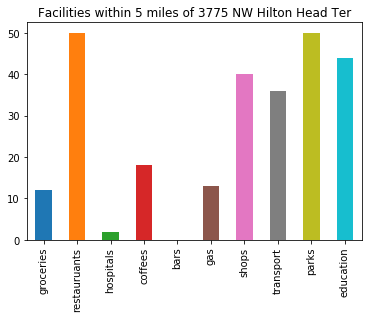

In [76]:
neighborhood_df.count().plot(kind='bar')
plt.title('Facilities within 5 miles of {}'.format(prop1.ADDRESS.values[0]))

### Find duration to commute to work

In [32]:
route_service_url = gis.properties.helperServices.route.url
route_service = RouteLayer(route_service_url, gis=gis)

In [33]:
stops = [paddress.values[0], '309 SW 6th Ave #600, Portland, OR 97204']
from arcgis.geocoding import geocode, batch_geocode
stops_geocoded = batch_geocode(stops)

stops_geocoded = [item['location'] for item in stops_geocoded]
stops_geocoded2 = '{},{};{},{}'.format(stops_geocoded[0]['x'],stops_geocoded[0]['y'],
                                       stops_geocoded[1]['x'],stops_geocoded[1]['y'])
stops_geocoded2

'-122.81532304999996,45.546748785000034;-122.67727209699996,45.52153932300007'

In [34]:
modes = route_service.retrieve_travel_modes()['supportedTravelModes']
for mode in modes:
    print(mode['name'])

Walking Time
Rural Driving Distance
Driving Time
Driving Distance
Walking Distance
Rural Driving Time
Trucking Time
Trucking Distance


In [35]:
route_service.properties.impedance

'TravelTime'

Calculate time it takes to get to work. Set start time as `8:00 AM` on Mondays. ArcGIS routing service will use historic averages, so we provide this time as `8:00 AM, Monday, June 4 1990` in Unix epoch time. Read more about this [here](https://developers.arcgis.com/rest/network/api-reference/route-synchronous-service.htm#ESRI_SECTION3_72F22EAF69BF4F6CB6076B583CEB4074)

In [36]:
route_result = route_service.solve(stops_geocoded2, return_routes=True, 
                             return_stops=True, return_directions=True,
                             impedance_attribute_name='TravelTime',
                             start_time=644511600000,
                             return_barriers=False, return_polygon_barriers=False,
                             return_polyline_barriers=False)

In [37]:
route_length = route_result['directions'][0]['summary']['totalLength']
route_duration = route_result['directions'][0]['summary']['totalTime']
route_duration_str = "{}m, {}s".format(int(route_duration), 
                                       round((route_duration %1)*60,2))
print("route length: {} miles, route duration: {}".format(round(route_length,3),
                                                         route_duration_str))

route length: 10.273 miles, route duration: 27m, 48.39s


In [49]:
route_features = route_result['routes']['features']
route_fset = FeatureSet(route_features)
stop_features = route_result['stops']['features']
stop_fset = FeatureSet(stop_features)

route_pop_up = {'title':'Name',
               'content':'Total_Miles'}
pdx_map2.draw(route_fset, symbol=route_symbol, popup=route_pop_up)

In [50]:
pdx_map2.draw(stop_fset, symbol=destination_symbol)